## **GMVAE**

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.nn import softmax, softplus
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy import stats


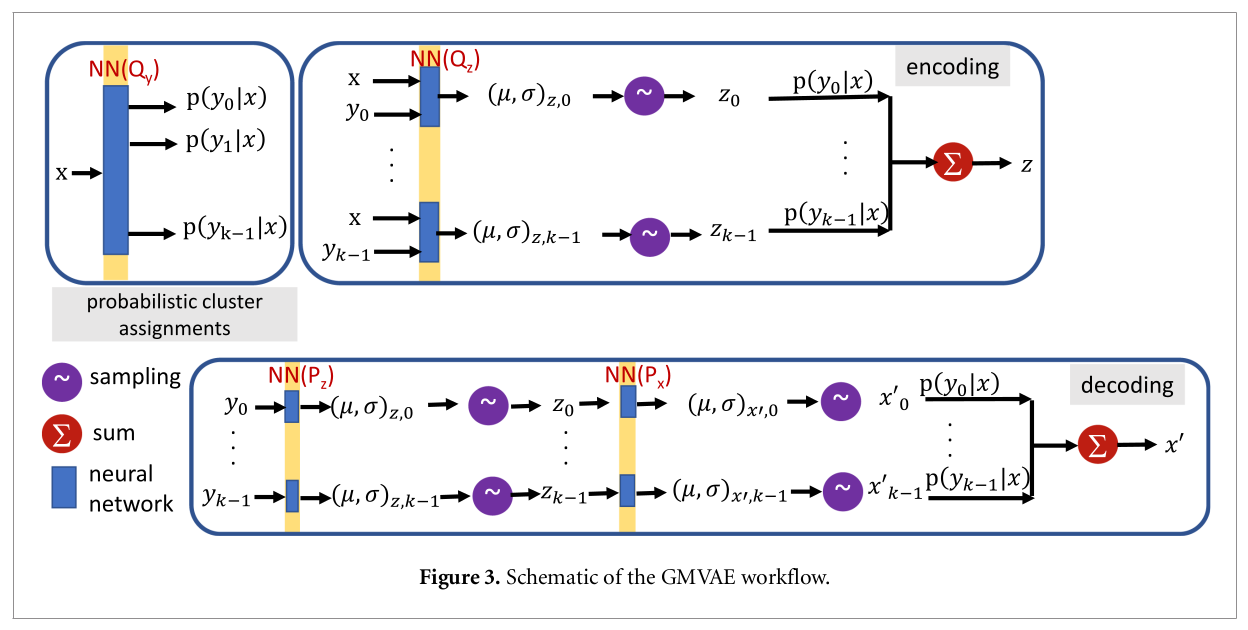

In [25]:
class GMVAE(tf.keras.Model):
    def __init__(self, k, n_z, n_x, qy_dims, qz_dims, pz_dims, px_dims, r_nent, batch_size, lr):
        super(GMVAE, self).__init__()

        """Build a GMM VAE model.
        
        Args:
            k (int): Number of mixture components.
            n_x (int): Number of observable dimensions.
            n_z (int): Number of hidden dimensions.
            qy_dims (iterable of int): Iterable of hidden dimensions in qy subgraph.
            qz_dims (iterable of int): Iterable of hidden dimensions in qz subgraph.
            pz_dims (iterable of int): Iterable of hidden dimensions in pz subgraph.
            px_dims (iterable of int): Iterable of hidden dimensions in px subgraph.
            r_nent (float): A constant for weighting negative entropy term in the loss.
            batch_size (int): Number of samples in each batch.
            lr (float): Learning rate.
        """

        self.k = k
        self.n_x = n_x
        self.n_z = n_z
        self.qy_dims = qy_dims
        self.qz_dims = qz_dims
        self.pz_dims = pz_dims
        self.px_dims = px_dims
        self.r_nent = r_nent
        self.batch_size = batch_size
        self.lr = lr
        
        # LAYERS:

        ## NN(Qy)
        use_batch_norm = True
        self.qy_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(qy_dims):
            self.qy_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                 use_bias=not use_batch_norm, 
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.qy_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.qy_nn.add(tf.keras.layers.Dense(k, activation='relu', kernel_initializer=None))

        ## NN(Qz)
        self.y_transform = tf.keras.layers.Dense(self.k, activation=None, kernel_initializer=None)
        self.qz_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(qz_dims):
            self.qz_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                    kernel_initializer=None))
            if use_batch_norm:
                self.qz_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.zm_layer = tf.keras.layers.Dense(n_z, activation=None, kernel_initializer=None)
        self.zv_layer = tf.keras.layers.Dense(n_z, activation=tf.nn.softplus, kernel_initializer=None) 
        
        ## NN(Pz)
        self.pz_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(pz_dims):
            self.pz_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu', 
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.pz_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.zm_prior_layer = tf.keras.layers.Dense(n_z, activation=None, kernel_initializer=None)
        self.zv_prior_layer = tf.keras.layers.Dense(n_z, activation=tf.nn.softplus, kernel_initializer=None)     
        
        ## NN(Px)
        self.px_nn = tf.keras.Sequential()
        for i, hidden_dim in enumerate(px_dims):
            self.px_nn.add(tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                 use_bias=not use_batch_norm, 
                                                 kernel_initializer=None))
            if use_batch_norm:
                self.px_nn.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
        self.xm_layer = tf.keras.layers.Dense(n_x, activation=None, kernel_initializer=None)
        self.xv_layer = tf.keras.layers.Dense(n_x, activation=tf.nn.softplus, kernel_initializer=None)
    
    @staticmethod
    def log_normal(x, mu, var, axis=-1):
        return -0.5 * tf.reduce_sum(tf.math.log(2 * np.pi) + tf.math.log(var) + tf.square(x - mu) / var, axis)

    def loss_function(self, k, x, xm, xv, z, zm, zv, zm_prior, zv_prior):
        return -self.log_normal(x, xm, xv) + self.log_normal(z, zm, zv) - self.log_normal(z, zm_prior, zv_prior) - tf.math.log(1/k)
    
    def call(self, data, training=None):
        y_ = tf.fill(tf.stack([tf.shape(data)[0], self.k]), 0.0)
        qy_logit = self.qy_nn(data)    #240000,k
        qy = tf.nn.softmax(qy_logit)   #240000,k
        
        zm_list, zv_list, z_list = [], [], []
        zm_prior_list, zv_prior_list, z_prior_list = [], [], []
        xm_list, xv_list, x_list = [], [], []

        for i in range(self.k):
            y = tf.add(y_, tf.constant(np.eye(self.k)[i], dtype=tf.float32, name=f'hot_at_{i:d}')) #240000,5
            

            ###Encoders###
            ##QZ            
            h0 = self.y_transform(y)
            xy = tf.concat([data, h0], 1)
            qz_logit = self.qz_nn(xy)         #240000,5
            zm = self.zm_layer(qz_logit)        #240000,n_z
            zv = self.zv_layer(qz_logit)        #240000,n_z
            zm_list.append(zm); zv_list.append(zv)     
            #Sample
            z_sample = tf.random.normal(tf.shape(zm), zm, stddev=tf.sqrt(zv))
            z_sample.set_shape(zm.get_shape())            
            zs = z_sample                           #240000,1
            z_list.append(zs)  
                   
            
            ### Decoders###
            ##PZ
            pz_logit = self.pz_nn(y)                      #240000,1  
            zm_prior = self.zm_prior_layer(pz_logit)      #240000,n_z
            zv_prior = self.zv_prior_layer(pz_logit)      #240000,n_z
            zm_prior_list.append(zm_prior); zv_prior_list.append(zv_prior)
            #Sample
            pz_sample = tf.random.normal(tf.shape(zm_prior), zm_prior, stddev=tf.sqrt(zv_prior))
            pz_sample.set_shape(zm_prior.get_shape())            
            z_prior = pz_sample                           #240000,1 
            z_prior_list.append(z_prior)
            
            ##PX
            px_logit = self.px_nn(z_prior)      #240000,1
            xm = self.xm_layer(px_logit)        #240000,n_x
            xv = self.xv_layer(px_logit)        #240000,n_x
            xm_list.append(xm); xv_list.append(xv)
            #Sample
            x_sample = tf.random.normal(tf.shape(xm), xm, stddev=tf.sqrt(xv))
            x_sample.set_shape(xm.get_shape())            
            xs = x_sample                           #240000,1   
            x_list.append(xs)
            
        
        nent = -tf.nn.softmax_cross_entropy_with_logits(labels=qy, logits=qy_logit)

        losses = [None] * self.k

        for i in range(self.k):
            losses[i] = self.loss_function(self.k, data, xm_list[i], xv_list[i], z_list[i], zm_list[i], zv_list[i], zm_prior_list[i], zv_prior_list[i])

        total_loss = tf.add_n([nent*self.r_nent] + [qy[:, i] * losses[i] for i in range(self.k)]) #?
        
        return qy_logit, qy, zm_list, zv_list, z_list, x_list, zm_prior_list, zv_prior_list, z_prior_list, xm_list, xv_list, total_loss, nent

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            _, _, _, _, _, _, _, _, _, _, _, total_loss, nent = self.call(data, training=True)
            

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return tf.reduce_mean(total_loss)

    def train(self, train_dataset, epochs):
      losses = np.empty(epochs)
      for epoch in range(epochs):
          if epoch == 0:
              print("Training:")
          
          epoch_loss = 0
          
          # Iterate over the batches of the dataset.
          for step, x_batch_train in enumerate(train_dataset):
              loss_value = self.train_step(x_batch_train)
              
              epoch_loss += loss_value
          
          losses[epoch] = epoch_loss / len(train_dataset)
          
          if epoch % 10 == 0 or epoch == 0:
              print(f"Loss for epoch {epoch}: {round(losses[epoch],2)}")
      
      return losses, epoch_loss


In [26]:
## DATA SETUP

data = np.load("/content/drive/MyDrive/UOC/TFM/GMVAE/traj_mb.npy")

data_list = []
for i in range(data.shape[0]):
    data_list.append(data[i, :, :])
data = data.reshape(-1, 2)
data = tf.convert_to_tensor(data)
data = tf.cast(data, dtype=tf.float32)

#Train and Test data:
train_size = int(0.99 * len(data))
x_train, x_test = data[:train_size], data[train_size:]

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=len(data))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test))


In [27]:
########################################### MAIN ########################################

# Hyperparameters
k, n_x, n_z, n_epochs = 5, 2, 1, 51
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.05
batch_size = 5000
lr = 1e-4

train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
test_dataset = train_dataset.batch(batch_size, drop_remainder=True)

# Instantiate Model
model = GMVAE(k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent, batch_size=batch_size, lr=lr)

# Optimizer
model.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Train Model
losses, epoch_loss = model.train(train_dataset, epochs=n_epochs)  


Training:
Loss for epoch 0: 4.52
Loss for epoch 10: 3.01
Loss for epoch 20: 2.72
Loss for epoch 30: 1.87
Loss for epoch 40: 1.32
Loss for epoch 50: 1.1


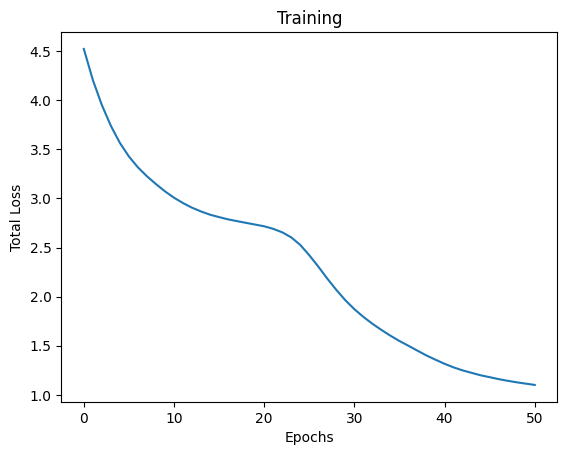

In [28]:
#Training: Loss vs Epoch Plot

plt.plot(range(0,len(losses)), losses)
plt.ylabel('Total Loss')
plt.xlabel('Epochs')
plt.title('Training')
plt.show()

In [29]:
# Testing:
data = tf.convert_to_tensor(data)
qy_logit, qy, zm_list, zv_list, z_list, x_list, zm_prior_list, zv_prior_list, z_prior_list, xm_list, xv_list, total_loss, nent = model.call(data)


In [30]:
# Latent and Reconstruction Calculations:

#Latent Space (z)
z = np.zeros(z_list[0].shape)
for z_i in range(z_list[0].shape[1]):
    for y_i in range(qy.shape[1]):
        z[:, z_i] += z_list[y_i][:,z_i]*qy[:,y_i]

#Reconstruction (x')
x = np.zeros(x_list[0].shape)
for x_i in range(x_list[0].shape[1]):
    for y_i in range(qy.shape[1]):
        x[:, x_i] += x_list[y_i][:, x_i]*qy[:, y_i]


In [31]:
# Clusters

qy=qy.numpy()

y_pred = np.argmax(qy, axis=1)
y_unq = np.unique(y_pred)
for i in range(len(y_unq)):
    y_pred[np.where(y_pred == y_unq[i])] = np.arange(0, len(y_unq))[i]

print("Clusters: ", y_unq)

Clusters:  [2 4]


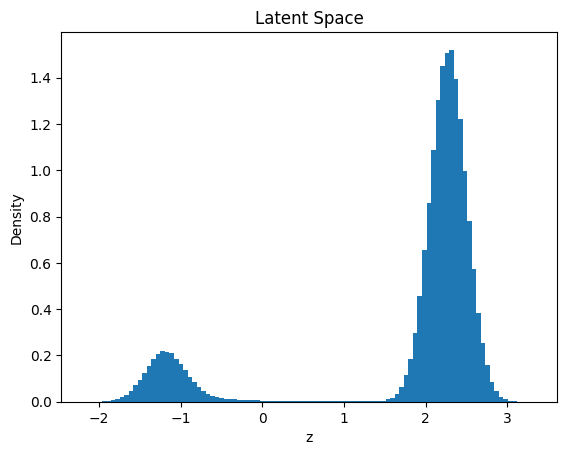

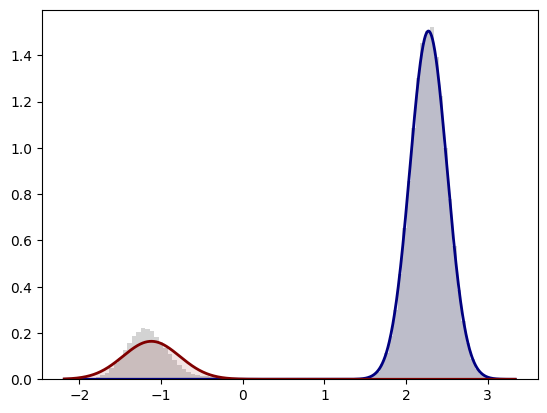

In [49]:
#Latent Space (z) Plot

plt.hist(z, bins=100, alpha=1, density=True)
plt.ylabel('Density')
plt.xlabel('z')
plt.title('Latent Space')
plt.show()


gmm = GaussianMixture(n_components=len(y_unq), random_state=0).fit(z)
ls = np.linspace(np.min(z), np.max(z), 1000).reshape(-1, 1)
gmm_densities = [weight * stats.norm(mean, np.sqrt(covariance)).pdf(ls)
                 for weight, mean, covariance in zip(gmm.weights_, gmm.means_, gmm.covariances_)]
plt.hist(z, bins=100, density=True, alpha=1, color='lightgrey')
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, len(y_unq))]
for gmm_density, color in zip(gmm_densities, colors):
    plt.plot(ls, gmm_density, color=color, linewidth=2)
    plt.fill_between(ls.flatten(), gmm_density.flatten(), color=color, alpha=0.1)
plt.show()

<ipython-input-48-2eeea9460052>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)


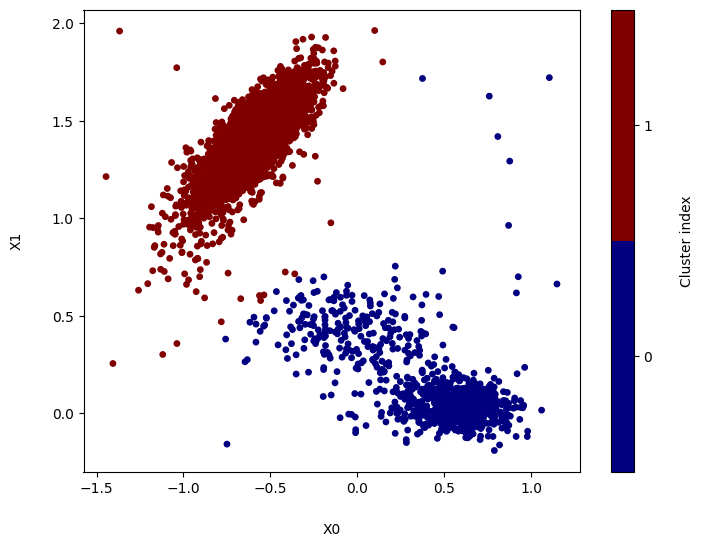

In [48]:
# FEL Clustering Plot (2D)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
sc = axes.scatter(data[::50, 0], data[::50, 1], c=y_pred[::50], alpha=1,
                  cmap=plt.cm.get_cmap('jet', len(np.unique(y_pred))), s=15)

cbar = fig.colorbar(sc, ax=axes)
cbar.set_alpha(1)
cbar.set_ticks(np.arange(0, 5, 1))
cbar.set_label('Cluster index', labelpad=20)

sc.set_alpha(1)
sc.set_clim(-0.5, len(np.unique(y_pred)) - 0.5)

axes.set_xlabel('X0', labelpad=20)
axes.set_ylabel('X1', labelpad=20)

plt.show()
